Results saved to CSV file.
     accuracy    recall  precision   roc_auc       mcc        f1    zscore  \
0    0.751724  0.773333   0.753247  0.750952  0.502575  0.763158  3.786427   
1    0.462069  0.173333   0.448276  0.472381 -0.069007  0.250000 -0.557008   
2    0.386207  0.066667   0.208333  0.397619 -0.275315  0.101010 -1.694575   
3    0.455172  0.186667   0.437500  0.464762 -0.084920  0.261682 -0.660423   
4    0.462069  0.280000   0.466667  0.468571 -0.067893  0.350000 -0.557008   
..        ...       ...        ...       ...       ...       ...       ...   
96   0.510345  0.266667   0.555556  0.519048  0.044064  0.360360  0.166898   
97   0.420690  0.360000   0.428571  0.422857 -0.155535  0.391304 -1.177499   
98   0.406897  0.160000   0.342857  0.415714 -0.196849  0.218182 -1.384329   
99   0.475862  0.346667   0.490566  0.480476 -0.040517  0.406250 -0.350178   
100  0.406897  0.200000   0.365854  0.414286 -0.190219  0.258621 -1.384329   

       pvalue  significancy  
0    0

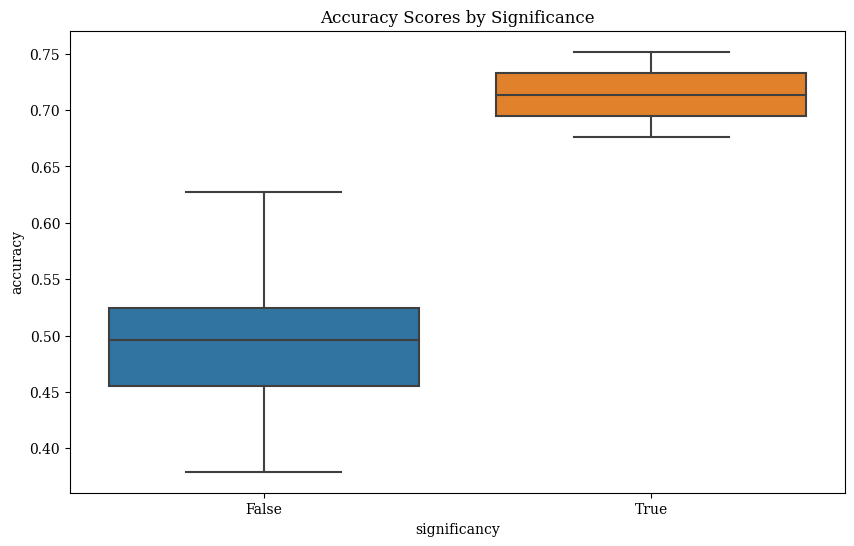

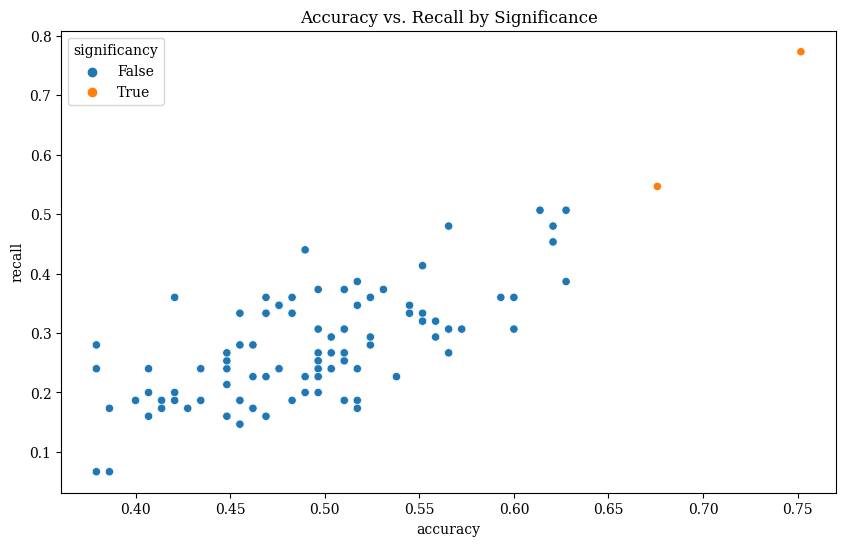

In [5]:
from sklearn.utils import shuffle 
import os
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,cross_validate, StratifiedKFold
from sklearn.utils  import shuffle
import joblib
import warnings
from sklearn.exceptions import DataConversionWarning
# 忽略特定类型的警告
warnings.filterwarnings("ignore", category=DataConversionWarning)

###########修改字体
from matplotlib import font_manager
# 查找系统中所有可用的Times New Roman字体的路径
times_new_roman = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 从列表中找到一个指定的字体名称
t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f]

if t_nr_path:
    # 如果找到了Times New Roman字体，设置为默认字体
    prop = font_manager.FontProperties(fname=t_nr_path[0])
    plt.rcParams['font.family'] = prop.get_name()
else:
    # 如果没有找到，使用另一种可用的衬线字体
    plt.rcParams['font.family'] = 'serif'


data = pd.read_csv('ADK-train-ECFPs.csv')
data2 = pd.read_csv('ADK-test-ECFPs.csv')
#x_mor = data.iloc[:,1:]
#y = data["type"]
#x_mor_train, x_mor_test, y_mor_train, y_mor_test = train_test_split(x_mor, y, test_size=0.2, stratify=y, 
                                                                   # random_state=13)
x_mor_train = data.iloc[:,2:]   #第三列以后的数据，Python中索引是从0开始的
y_mor_train = data.iloc[:,1:2]  #左开右闭，读取第二列的数据
x_mor_test = data2.iloc[:,2:]
y_mor_test = data2.iloc[:,1:2]

# X = x_mor_train    #x_mor_train 是输入特征，
# Y = y_mor_train    #y_mor_train 是对应的目标变量（即标签）。
columns = "ECFPs"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)    
#K折交叉验证（Stratified K-Fold Cross Validation）
#shuffle=True 表示在每次分割前都会对数据进行随机洗牌
#random_state=0 是设置随机种子，确保结果的可重复性。

# 模型扰动
from y_scramble import Scrambler  # 确保y_scramble已正确安装和可用
from sklearn.ensemble import AdaBoostClassifier

# 设置训练集和测试集的特征和标签
X_train = x_mor_train
Y_train = y_mor_train
X_test = x_mor_test
Y_test = y_mor_test

# 使用找到的最佳参数实例化AdaBoost分类器
Ada = AdaBoostClassifier(random_state = 0,
                         algorithm = 'SAMME',
                         learning_rate = 1,
                         n_estimators = 479)

# 训练模型
Ada.fit(X_train, Y_train)

# 确保X和Y被正确赋值为训练数据集和标签
# 转换Y_train为numpy数组以避免KeyError
Y_train_np = Y_train.values.ravel()

# 确保X和Y被正确赋值为训练数据集和标签
X = X_train
Y = Y_train_np  # 使用Y_train转换为numpy数组的版本

# 初始化Scrambler实例
scrambler = Scrambler(model=Ada, iterations=100)

# 使用Scrambler的validate验证模型，假设以DataFrame形式返回了结果
results = scrambler.validate(
    X=X_train, 
    Y=Y_train_np, 
    scoring="accuracy", # 注意: 'scoring'参数在当前实现中不直接影响结果，因为返回了多个评价指标
    cross_val_score_aggregator="mean", 
    pvalue_threshold=0.01,
    as_df=True  # 假设我们想直接以DataFrame形式获取结果
)

# 检查是否返回了DataFrame
if isinstance(results, pd.DataFrame):
    # 将DataFrame保存到CSV文件
    results.to_csv("validation_results.csv", index=False)
    print("Results saved to CSV file.")
    print(results)
else:
    # 如果返回的不是DataFrame，则进行解包
    accuracy_scores, recall_scores, precision_scores, rou_auc_scores, matthews_corrcoef_scores, f1_scores, zscores, pvalues, significances = results
    print("Accuracy Scores:", accuracy_scores)
    print("Recall Scores:", recall_scores)
    print("Precision Scores:", precision_scores)
    print("Roc_auc Scores:", rou_auc_scores)
    print("Mcc Scores:", matthews_corrcoef_scores)
    print("F1 Scores:", f1_scores)
    print("Z-Scores:", zscores)
    print("P-Values:", pvalues)
    print("Significances:", significances)

import pandas as pd
import numpy as np

# 随机提取10次模型扰动的结果
if len(results) > 10:
    # 随机选取10次扰动的索引，排除第0行（原始模型的评分）
    random_indices = np.random.choice(results.index[1:], size=10, replace=False)
    # 使用iloc直接选择这些索引的行
    selected_scrambled_metrics = results.iloc[random_indices]
    # 保存选取的扰动模型指标到CSV
    selected_scrambled_metrics.to_csv("selected_scrambled_metrics.csv", index=False)
else:
    print("Not enough data to select from.")


# 假设results是已经通过validate方法获得的DataFrame，并且包含了原始模型的数据在第一行
original_model_data = results.iloc[0]

# 创建一个DataFrame来存储原始模型指标
original_model_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'MCC', 'f1', 'Z-Score', 'P-Value', 'Significance'],
    'Value': [
        original_model_data['accuracy'],
        original_model_data['recall'],
        original_model_data['precision'],
        original_model_data['roc_auc'],
        original_model_data['mcc'],
        original_model_data['f1'],
        original_model_data['zscore'],
        original_model_data['pvalue'],
        '显著' if original_model_data['significancy'] else '不显著'
    ]
})

# 将DataFrame保存到CSV文件
original_model_metrics_df.to_csv("original_model_metrics.csv", index=False)

# 模型扰动结果可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 筛选显著性结果
significant_results = results[results['significancy']]

# 绘制准确率的箱形图
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='significancy', y='accuracy')
plt.title('Accuracy Scores by Significance')
plt.show()

# 绘制准确率和召回率的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='accuracy', y='recall', hue='significancy')
plt.title('Accuracy vs. Recall by Significance')
plt.show()



Results saved to CSV file.
     accuracy    recall  precision   roc_auc       mcc        f1    zscore  \
0    0.689655  0.656716   0.666667  0.687333  0.375096  0.661654  3.438120   
1    0.482759  0.194030   0.382353  0.462400 -0.088493  0.257426 -0.465029   
2    0.489655  0.313433   0.428571  0.477229 -0.048002  0.362069 -0.334924   
3    0.593103  0.522388   0.564516  0.588117  0.177599  0.542636  1.616651   
4    0.531034  0.432836   0.491525  0.524110  0.048937  0.460317  0.445706   
..        ...       ...        ...       ...       ...       ...       ...   
96   0.524138  0.373134   0.480769  0.513490  0.028047  0.420168  0.315601   
97   0.482759  0.313433   0.420000  0.470819 -0.061216  0.358974 -0.465029   
98   0.482759  0.388060   0.433333  0.476081 -0.048425  0.409449 -0.465029   
99   0.489655  0.358209   0.436364  0.480387 -0.040306  0.393443 -0.334924   
100  0.579310  0.432836   0.557692  0.568982  0.143419  0.487395  1.356441   

       pvalue  significancy  
0    0

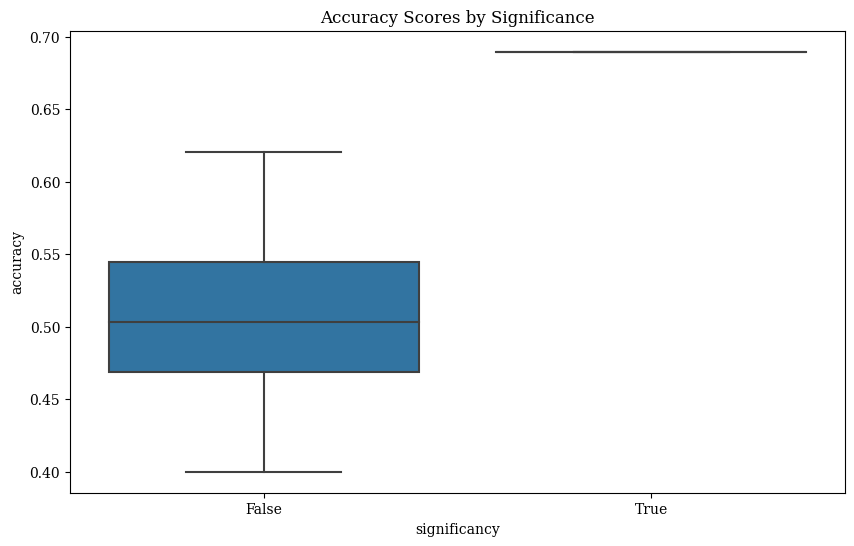

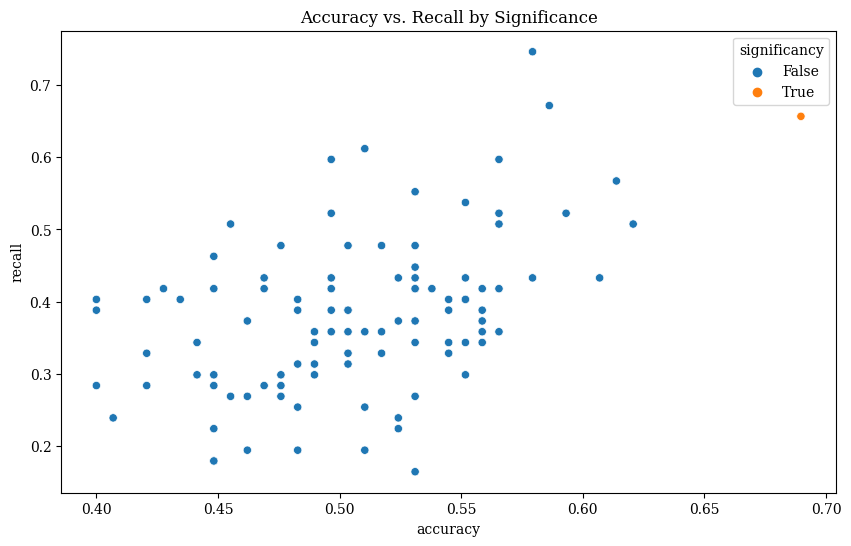

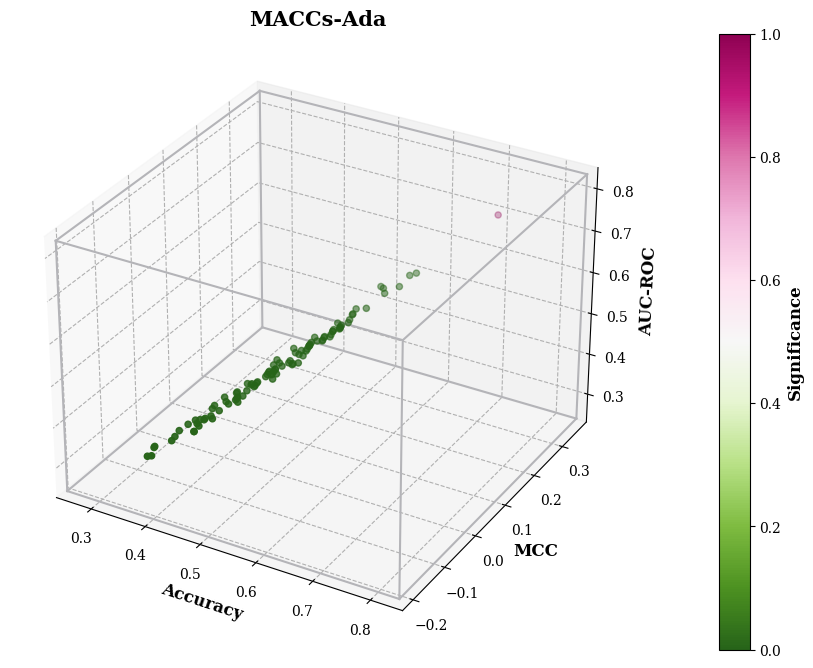

In [6]:
# 模型扰动
from y_scramble import Scrambler  # 确保y_scramble已正确安装和可用
from sklearn.ensemble import AdaBoostClassifier   #算法

# 设置训练集和测试集的特征和标签
X_train = x_mor_train
Y_train = y_mor_train
X_test = x_mor_test
Y_test = y_mor_test

# 使用找到的最佳参数实例化AdaBoost分类器
Ada = AdaBoostClassifier(random_state = 0,
                         algorithm = 'SAMME',
                         learning_rate = 1.5,
                         n_estimators = 166)

# 训练模型
Ada.fit(X_train, Y_train)     ####需修改

# 确保X和Y被正确赋值为训练数据集和标签
# 转换Y_train为numpy数组以避免KeyError
Y_train_np = Y_train.values.ravel()

# 确保X和Y被正确赋值为训练数据集和标签
X = X_train
Y = Y_train_np  # 使用Y_train转换为numpy数组的版本

# 初始化Scrambler实例 
scrambler = Scrambler(model=Ada, iterations=100)   #model=Ada  

# 使用Scrambler的validate验证模型，假设以DataFrame形式返回了结果
results = scrambler.validate(
    X=X_train, 
    Y=Y_train_np, 
    scoring="accuracy", # 注意: 'scoring'参数在当前实现中不直接影响结果，因为返回了多个评价指标
    cross_val_score_aggregator="mean", 
    pvalue_threshold=0.01,
    as_df=True  # 假设我们想直接以DataFrame形式获取结果
)

# 检查是否返回了DataFrame
if isinstance(results, pd.DataFrame):
    # 将DataFrame保存到CSV文件
    results.to_csv("validation_results.csv", index=False)
    print("Results saved to CSV file.")
    print(results)
else:
    # 如果返回的不是DataFrame，则进行解包
    accuracy_scores, recall_scores, precision_scores, rou_auc_scores, matthews_corrcoef_scores, f1_scores, zscores, pvalues, significances = results
    print("Accuracy Scores:", accuracy_scores)
    print("Recall Scores:", recall_scores)
    print("Precision Scores:", precision_scores)
    print("Roc_auc Scores:", rou_auc_scores)
    print("Mcc Scores:", matthews_corrcoef_scores)
    print("F1 Scores:", f1_scores)
    print("Z-Scores:", zscores)
    print("P-Values:", pvalues)
    print("Significances:", significances)

import pandas as pd
import numpy as np

# 随机提取10次模型扰动的结果
if len(results) > 10:
    # 随机选取10次扰动的索引，排除第0行（原始模型的评分）
    random_indices = np.random.choice(results.index[1:], size=10, replace=False)
    # 使用iloc直接选择这些索引的行
    selected_scrambled_metrics = results.iloc[random_indices]
    # 保存选取的扰动模型指标到CSV
    selected_scrambled_metrics.to_csv("selected_scrambled_metrics.csv", index=False)
else:
    print("Not enough data to select from.")


# 假设results是已经通过validate方法获得的DataFrame，并且包含了原始模型的数据在第一行
original_model_data = results.iloc[0]

# 创建一个DataFrame来存储原始模型指标
original_model_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'MCC', 'f1', 'Z-Score', 'P-Value', 'Significance'],
    'Value': [
        original_model_data['accuracy'],
        original_model_data['recall'],
        original_model_data['precision'],
        original_model_data['roc_auc'],
        original_model_data['mcc'],
        original_model_data['f1'],
        original_model_data['zscore'],
        original_model_data['pvalue'],
        '显著' if original_model_data['significancy'] else '不显著'
    ]
})

# 将DataFrame保存到CSV文件
original_model_metrics_df.to_csv("original_model_metrics.csv", index=False)

# 模型扰动结果可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 筛选显著性结果
significant_results = results[results['significancy']]

# 绘制准确率的箱形图
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='significancy', y='accuracy')
plt.title('Accuracy Scores by Significance')
plt.show()

# 绘制准确率和召回率的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='accuracy', y='recall', hue='significancy')
plt.title('Accuracy vs. Recall by Significance')
plt.show()


import matplotlib.pyplot as plt
#from matplotlib.font_manager import findfont, FontProperties
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

# 设置字体大小
plt.rcParams['font.size'] = 10

# 假设 'results' 已经包含所需的数据列
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 散点图
scatter = ax.scatter(
    results['accuracy'],
    results['mcc'],
    results['roc_auc'],
    c=results['significancy'],
    cmap='PiYG_r',   #内置颜色
    marker='o'
)

# 添加轴标签，使用字体大小12和粗体
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('MCC', fontsize=12, fontweight='bold')
ax.set_zlabel('AUC-ROC', fontsize=12, fontweight='bold')

# 添加标题，使用字体大小15和粗体
ax.set_title('MACCs-Ada', fontsize=15, fontweight='bold')

# 画线定义立方体
max_range = np.array([results['accuracy'].max()-results['accuracy'].min(), 
                      results['mcc'].max()-results['mcc'].min(), 
                      results['roc_auc'].max()-results['roc_auc'].min()]).max() / 2.0

mid_x = (results['accuracy'].max()+results['accuracy'].min()) * 0.5
mid_y = (results['mcc'].max()+results['mcc'].min()) * 0.5
mid_z = (results['roc_auc'].max()+results['roc_auc'].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 更改网格线为虚线
ax.xaxis._axinfo["grid"]['linestyle'] = "--"
ax.yaxis._axinfo["grid"]['linestyle'] = "--"
ax.zaxis._axinfo["grid"]['linestyle'] = "--"
ax.grid(True)

# 生成各顶点
x = [mid_x - max_range, mid_x + max_range]
y = [mid_y - max_range, mid_y + max_range]
z = [mid_z - max_range, mid_z + max_range]

# 绘制线条
for xi in x:
    for yi in y:
        ax.plot([xi, xi], [yi, yi], z, linestyle="-", color="#B4B4B8")

for xi in x:
    for zi in z:
        ax.plot([xi, xi], y, [zi, zi], linestyle="-", color="#B4B4B8")

for yi in y:
    for zi in z:
        ax.plot(x, [yi, yi], [zi, zi], linestyle="-", color="#B4B4B8")

# 颜色条，使用字体大小12和粗体
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Significance', fontsize=12, fontweight='bold')

# Saving the plot as SVG with a high quality
plt.savefig("MACCs_Ada.svg", format='svg', dpi=600)
plt.show() # 显示图形